
=== DLS Particle Size Distribution Plotter (Triplicate Version) ===

Select all particle size distribution files (Ctrl+Click for multiple files)

File categorization:
  DBPC HMSN: 3 files
    - 1_DBPC HMSN_2025-08-25-16-23-32_.xlsx
    - 2_DBPC HMSN_2025-08-25-16-29-17_.xlsx
    - 3_DBPC HMSN_2025-08-25-16-40-43_.xlsx
  MSN: 3 files
    - 4_MSN_2025-08-25-16-51-29_.xlsx
    - 5_MSN_2025-08-25-16-59-53_.xlsx
    - 6_MSN_2025-08-25-17-09-15_.xlsx

✓ Triplicates detected for DBPC HMSN

✓ Triplicates detected for MSN

Checking available frequency weightings...

Multiple frequency weightings found: Intensity weighted, Volume weighted, Number weighted

Select which weighting to use:
  1. Intensity weighted
  2. Volume weighted
  3. Number weighted


Enter choice (1-3) [default: 1]:  3


Selected weighting: Number weighted

Loading all files with Number weighted...

DBPC HMSN files:
  Loaded: 1_DBPC HMSN_2025-08-25-16-23-32_ (142 points, 101 zeros)
  Loaded: 2_DBPC HMSN_2025-08-25-16-29-17_ (142 points, 114 zeros)
  Loaded: 3_DBPC HMSN_2025-08-25-16-40-43_ (142 points, 115 zeros)

MSN files:
  Loaded: 4_MSN_2025-08-25-16-51-29_ (142 points, 106 zeros)
  Loaded: 5_MSN_2025-08-25-16-59-53_ (142 points, 106 zeros)
  Loaded: 6_MSN_2025-08-25-17-09-15_ (142 points, 110 zeros)

Analyzing data range...

Data analysis:
  - Minimum diameter in data: 0.2 nm
  - Maximum diameter in data: 19095.4 nm
  - 99.9% of cumulative frequency at: 4443.9 nm
  - Suggested truncation: 6500 nm

Truncation options:
  1. Automatic (recommended): 6500 nm
  2. Manual: Enter your own value
  3. No truncation: Show all data



Select option (1/2/3) [default: 1]:  1


Using automatic truncation at 6500 nm

X-axis scale options:
  1. Linear scale (default)
  2. Log scale



Select scale option (1/2) [default: 1]:  2


Using logarithmic scale for x-axis



Do you want to save the plot? (y/n):  y



Default save location: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/DLS and Zeta Potential/25AUG25/DLS
Default filename: DLS_averaged_Number_weighted_truncated6500nm_logscale.png


Enter filename (press Enter for default):  



File already exists. Saving as: DLS_averaged_Number_weighted_truncated6500nm_logscale_2.png

Plot saved to: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/DLS and Zeta Potential/25AUG25/DLS\DLS_averaged_Number_weighted_truncated6500nm_logscale_2.png
Size: 3.17" × 1.82" at 600 DPI


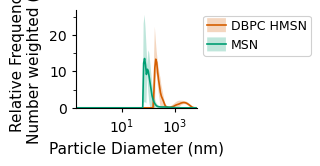


Plotting complete!

Note: Data shown as mean ± SD for triplicates
X-axis displayed in logarithmic scale


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import tkinter as tk
from tkinter import filedialog
import os
import re
import warnings

"""DLS (Particle Size Distribution) Plotter with Triplicate Averaging
Small panel version: 2.57" x 1.82" for publication
Now includes log scale option for x-axis
"""

warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# Small panel dimensions and font sizes
PANEL_W_IN, PANEL_H_IN = 3.17, 1.82
EXPORT_DPI = 600
AXIS_FS, TICK_FS, LEGEND_FS = 11, 10, 9

def find_particle_data_columns(df):
    """Find diameter and all frequency columns with flexible matching"""
    diameter_col = None
    frequency_cols = {}
    
    diameter_patterns = [
        r'particle.*diameter',
        r'diameter.*nm',
        r'size.*nm',
        r'particle.*size',
        r'd.*nm',
    ]
    
    for col in df.columns:
        col_str = str(col)
        col_lower = col_str.lower()
        
        if not diameter_col:
            for pattern in diameter_patterns:
                if re.search(pattern, col_lower):
                    diameter_col = col
                    break
        
        if 'frequency' in col_lower or 'intensity' in col_lower:
            display_name = col_str
            
            if 'number' in col_lower:
                display_name = 'Number weighted'
            elif 'volume' in col_lower:
                display_name = 'Volume weighted'
            elif 'intensity' in col_lower and 'frequency' in col_lower:
                display_name = 'Intensity weighted'
            else:
                if re.search(r'frequency.*\d', col_lower):
                    display_name = col_str.replace('.', ' ')
                else:
                    display_name = col_str
            
            frequency_cols[display_name] = col
    
    return diameter_col, frequency_cols

def load_particle_data_with_selection(file_path, preferred_weighting='Number weighted'):
    """Load particle size distribution data from Excel file"""
    try:
        if file_path.endswith(('.xlsx', '.xls')):
            xl_file = pd.ExcelFile(file_path)
            
            for sheet_name in xl_file.sheet_names:
                df_raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
                
                for idx in range(min(30, len(df_raw))):
                    row = df_raw.iloc[idx]
                    
                    diameter_col_idx = None
                    for col_idx, cell in enumerate(row):
                        if pd.notna(cell) and 'particle diameter' in str(cell).lower():
                            diameter_col_idx = col_idx
                            break
                    
                    if diameter_col_idx is not None:
                        if idx + 1 < len(df_raw):
                            weight_row = df_raw.iloc[idx + 1]
                            
                            frequency_info = []
                            for col_idx, cell in enumerate(row):
                                if pd.notna(cell) and 'relative frequency' in str(cell).lower():
                                    if col_idx < len(weight_row):
                                        weight = str(weight_row.iloc[col_idx])
                                        if 'intensity' in weight.lower():
                                            frequency_info.append(('Intensity weighted', col_idx))
                                        elif 'volume' in weight.lower():
                                            frequency_info.append(('Volume weighted', col_idx))
                                        elif 'number' in weight.lower():
                                            frequency_info.append(('Number weighted', col_idx))
                            
                            if frequency_info:
                                data_start_row = idx + 2
                                
                                valid_freq_cols = {}
                                for name, col_idx in frequency_info:
                                    col_data = df_raw.iloc[data_start_row:, col_idx]
                                    numeric_data = pd.to_numeric(col_data, errors='coerce')
                                    if numeric_data.notna().any():
                                        valid_freq_cols[name] = col_idx
                                
                                if valid_freq_cols:
                                    freq_col_idx = None
                                    freq_name = preferred_weighting
                                    
                                    for name, col_idx in valid_freq_cols.items():
                                        if preferred_weighting.lower() in name.lower():
                                            freq_col_idx = col_idx
                                            freq_name = name
                                            break
                                    
                                    if freq_col_idx is None:
                                        freq_name = list(valid_freq_cols.keys())[0]
                                        freq_col_idx = valid_freq_cols[freq_name]
                                    
                                    diameter_data = df_raw.iloc[data_start_row:, diameter_col_idx]
                                    frequency_data = df_raw.iloc[data_start_row:, freq_col_idx]
                                    
                                    data = pd.DataFrame({
                                        'Diameter (nm)': pd.to_numeric(diameter_data, errors='coerce'),
                                        'Relative Frequency': pd.to_numeric(frequency_data, errors='coerce')
                                    })
                                    
                                    data = data.dropna()
                                    data = data[data['Diameter (nm)'] > 0]
                                    
                                    if len(data) > 0:
                                        return data, freq_name, list(valid_freq_cols.keys())
        
        elif file_path.endswith('.txt'):
            for sep in [r'\s+', '\t', ',', ';']:
                try:
                    data = pd.read_csv(file_path, sep=sep, header=None, names=["Diameter (nm)", "Relative Frequency"])
                    if len(data) > 0 and data['Diameter (nm)'].dtype in [np.float64, np.int64]:
                        data = data[data['Diameter (nm)'] > 0]
                        if len(data) > 0:
                            return data, "Default", ["Default"]
                except:
                    continue
        
        raise ValueError("Could not find valid particle size distribution data")
        
    except Exception as e:
        raise Exception(f"Error: {str(e)}")

def extract_ph_from_filename(filename):
    """Extract pH value from filename if present"""
    ph_patterns = [
        r'ph[_\s]*(\d+\.?\d*)',
        r'ph[_\s]*(\d+)',
    ]
    
    filename_lower = filename.lower()
    for pattern in ph_patterns:
        match = re.search(pattern, filename_lower)
        if match:
            ph_val = match.group(1)
            if '.' in ph_val and ph_val.endswith('0'):
                ph_val = ph_val.rstrip('0').rstrip('.')
            return ph_val
    
    return None

def categorize_files_smart(file_paths):
    """Smart categorization for files"""
    categories = {}
    
    for file_path in file_paths:
        filename = os.path.basename(file_path).lower()
        
        # Simple categorization for these specific files
        if 'dbpc' in filename and 'hmsn' in filename:
            category = 'DBPC HMSN'
        elif 'dppc' in filename and 'hmsn' in filename:
            category = 'DPPC HMSN'
        elif 'msn' in filename:
            category = 'MSN'
        elif 'hmsn' in filename:
            category = 'HMSN'
        else:
            category = 'Other'
        
        if category not in categories:
            categories[category] = []
        categories[category].append(file_path)
    
    return categories

def average_triplicates(data_list):
    """
    Average multiple DLS measurements at each diameter point
    Returns averaged data with standard deviation
    """
    if len(data_list) == 0:
        return None, None
    if len(data_list) == 1:
        # Single measurement - no std dev
        df = data_list[0][0]
        avg_df = df.copy()
        avg_df['Std Dev'] = 0
        return avg_df, None
    
    # Extract just the dataframes
    dfs = [item[0] for item in data_list]
    
    # Find common diameter range
    min_diameter = max(df['Diameter (nm)'].min() for df in dfs)
    max_diameter = min(df['Diameter (nm)'].max() for df in dfs)
    
    # Create common diameter grid
    all_diameters = pd.concat([df['Diameter (nm)'] for df in dfs])
    common_diameters = all_diameters[(all_diameters >= min_diameter) & 
                                     (all_diameters <= max_diameter)].unique()
    common_diameters = np.sort(common_diameters)
    
    # Interpolate all curves to common grid
    interpolated = []
    for df in dfs:
        f = np.interp(common_diameters, 
                     df['Diameter (nm)'].values, 
                     df['Relative Frequency'].values)
        interpolated.append(f)
    
    # Calculate mean and std
    interpolated = np.array(interpolated)
    mean_freq = np.mean(interpolated, axis=0)
    std_freq = np.std(interpolated, axis=0, ddof=1) if len(interpolated) > 1 else np.zeros_like(mean_freq)
    
    # Create averaged dataframe
    avg_df = pd.DataFrame({
        'Diameter (nm)': common_diameters,
        'Relative Frequency': mean_freq,
        'Std Dev': std_freq
    })
    
    return avg_df, interpolated

def analyze_data_range(data_by_category):
    """Analyze data to find smart truncation point"""
    all_diameters = []
    all_frequencies = []
    for category, data_list in data_by_category.items():
        for data, _, _ in data_list:
            all_diameters.extend(data['Diameter (nm)'].values)
            all_frequencies.extend(data['Relative Frequency'].values)
    
    all_diameters = np.array(all_diameters)
    all_frequencies = np.array(all_frequencies)
    
    sort_idx = np.argsort(all_diameters)
    sorted_diameters = all_diameters[sort_idx]
    sorted_frequencies = all_frequencies[sort_idx]
    
    cumsum_freq = np.cumsum(sorted_frequencies)
    if cumsum_freq[-1] > 0:
        cumsum_normalized = cumsum_freq / cumsum_freq[-1]
        idx_999 = np.where(cumsum_normalized >= 0.999)[0]
        if len(idx_999) > 0:
            diameter_999 = sorted_diameters[idx_999[0]]
        else:
            diameter_999 = sorted_diameters[-1]
    else:
        diameter_999 = sorted_diameters[-1]
    
    max_freq = np.max(all_frequencies)
    if max_freq > 0:
        significant_data = sorted_diameters[sorted_frequencies > 0.001 * max_freq]
        if len(significant_data) > 0:
            diameter_cutoff = significant_data[-1]
        else:
            diameter_cutoff = sorted_diameters[-1]
    else:
        diameter_cutoff = sorted_diameters[-1]
    
    suggested_truncation = min(diameter_999, diameter_cutoff) * 1.5
    
    if suggested_truncation > 1000:
        suggested_truncation = round(suggested_truncation / 500) * 500
    elif suggested_truncation > 100:
        suggested_truncation = round(suggested_truncation / 100) * 100
    else:
        suggested_truncation = round(suggested_truncation / 10) * 10
    
    suggested_truncation = max(suggested_truncation, 100)
    
    return {
        'max_diameter': sorted_diameters[-1],
        'diameter_999': diameter_999,
        'diameter_cutoff': diameter_cutoff,
        'suggested_truncation': suggested_truncation,
        'min_diameter': sorted_diameters[0]  # Added for log scale consideration
    }

def create_plot_with_triplicates(data_by_category, title, weighting_choice, max_diameter=None, use_log_scale=False):
    """Create plot with averaged triplicates and error regions
    
    Parameters:
    -----------
    use_log_scale : bool
        If True, use logarithmic scale for x-axis (particle diameter)
    """
    
    from matplotlib.lines import Line2D
    import matplotlib.patches as mpatches
    
    # Custom legend handler class for shaded error bars
    class LineWithShade:
        def __init__(self, color, has_shade=True):
            self.color = color
            self.has_shade = has_shade
            
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height
            
            # Create the shaded background if needed
            if self.has_shade:
                shade = mpatches.FancyBboxPatch(
                    (x0, y0 - height * 0.3), width, height * 1.6,
                    boxstyle="round,pad=0", 
                    facecolor=self.color, 
                    alpha=0.25,
                    edgecolor='none',
                    transform=handlebox.get_transform()
                )
                handlebox.add_artist(shade)
            
            # Create the solid line
            line = Line2D([x0, x0 + width], [y0 + height/2, y0 + height/2],
                         color=self.color, linewidth=1.2,
                         transform=handlebox.get_transform())
            handlebox.add_artist(line)
            
            return line
    
    fig, ax = plt.subplots(figsize=(PANEL_W_IN, PANEL_H_IN))
    
    # Colors
    category_colors = {
        'DBPC HMSN': '#D55E00',  # Orange
        'DPPC HMSN': '#D55E00',  # Orange
        'MSN': '#009E73',         # Green
        'HMSN': '#0072B2',        # Blue
        'Other': '#999999'        # Grey
    }
    
    legend_handles = []
    legend_labels = []
    legend_handler_map = {}
    
    for cat_idx, (category, data_list) in enumerate(data_by_category.items()):
        if not data_list:
            continue
        
        color = category_colors.get(category, '#666666')
        
        # Average the triplicates
        avg_data, individual_curves = average_triplicates(data_list)
        
        if avg_data is not None:
            # Apply diameter filter if specified
            if max_diameter:
                avg_data = avg_data[avg_data["Diameter (nm)"] <= max_diameter]
            
            if len(avg_data) == 0:
                continue
            
            # Plot average curve
            line = ax.plot(
                avg_data["Diameter (nm)"],
                avg_data["Relative Frequency"],
                color=color,
                linewidth=1.2,
                linestyle='-'
            )[0]
            
            # Add shaded error region if we have triplicates
            if len(data_list) > 1:
                ax.fill_between(
                    avg_data["Diameter (nm)"],
                    avg_data["Relative Frequency"] - avg_data["Std Dev"],
                    avg_data["Relative Frequency"] + avg_data["Std Dev"],
                    color=color,
                    alpha=0.25,
                    edgecolor='none'
                )
                # Create custom handle with shade
                handle = Line2D([0], [0], color=color)
                legend_handler_map[handle] = LineWithShade(color, has_shade=True)
                legend_handles.append(handle)
            else:
                # Just normal line if no error bars
                handle = Line2D([0], [0], color=color)
                legend_handler_map[handle] = LineWithShade(color, has_shade=False)
                legend_handles.append(handle)
            
            legend_labels.append(category)
    
    # Formatting
    ax.set_xlabel("Particle Diameter (nm)", fontsize=AXIS_FS)
    ax.set_ylabel(f"Relative Frequency\n{weighting_choice} (%)", fontsize=AXIS_FS, labelpad=5)
    
    # Set scale
    if use_log_scale:
        ax.set_xscale('log')
        # For log scale, we need to handle x-limits carefully
        if max_diameter:
            # Find minimum diameter that's > 0 in the data
            min_diam = float('inf')
            for category, data_list in data_by_category.items():
                for data, _, _ in data_list:
                    positive_diams = data[data['Diameter (nm)'] > 0]['Diameter (nm)']
                    if len(positive_diams) > 0:
                        min_diam = min(min_diam, positive_diams.min())
            
            if min_diam < float('inf'):
                # Set limits with some padding for log scale
                ax.set_xlim(left=min_diam * 0.9, right=max_diameter)
            else:
                ax.set_xlim(left=1, right=max_diameter)
        else:
            # Auto scale will handle it
            pass
    else:
        # Linear scale
        if max_diameter:
            ax.set_xlim(left=0, right=max_diameter)
    
    ax.set_ylim(bottom=0)
    
    ax.tick_params(axis='both', which='major', labelsize=TICK_FS, length=3, width=0.8, direction='out')
    ax.tick_params(axis='both', which='minor', length=2, width=0.6, direction='out')
    ax.grid(False)
    
    for sp in ax.spines.values():
        sp.set_linewidth(0.8)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set up minor ticks properly
    if not use_log_scale:
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    # For log scale, matplotlib handles minor ticks automatically
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # Legend with custom handler for shaded error bars
    leg = ax.legend(
        legend_handles,
        legend_labels,
        handler_map=legend_handler_map,
        fontsize=LEGEND_FS,
        loc='upper left',
        bbox_to_anchor=(1.005, 1),
        frameon=True,
        fancybox=True,
        framealpha=1.0,
        handlelength=1.5,
        handletextpad=0.4,
        borderpad=0.3
    )
    leg.get_frame().set_edgecolor("#D0D0D0")
    leg.get_frame().set_linewidth(0.8)
    
    # Margins adjusted for 3.29" width
    fig.subplots_adjust(left=0.22, right=0.60, bottom=0.26, top=0.8)
    
    # No title
    
    return fig

def plot_particle_distributions():
    """Main function to select files and plot particle size distributions"""
    
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    root.lift()
    root.focus_force()
    root.update()
    
    try:
        default_dir = r"C:\Users\Talaial Alina\OneDrive - UCB-O365\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\DLS and Zeta Potential"
        
        if not os.path.exists(default_dir):
            default_dir = os.getcwd()
        
        print("\n=== DLS Particle Size Distribution Plotter (Triplicate Version) ===")
        print("\nSelect all particle size distribution files (Ctrl+Click for multiple files)")
        
        all_files = filedialog.askopenfilenames(
            parent=root,
            initialdir=default_dir,
            title="Select all particle size distribution files",
            filetypes=[("Excel files", "*.xlsx *.xls"), ("Text files", "*.txt"), ("All files", "*.*")]
        )
        
        root.destroy()
        
        if not all_files:
            print("No files selected. Exiting.")
            return
        
        save_dir = os.path.dirname(all_files[0])
        
        file_categories = categorize_files_smart(all_files)
        
        print("\nFile categorization:")
        for category, files in file_categories.items():
            print(f"  {category}: {len(files)} files")
            for f in files:
                print(f"    - {os.path.basename(f)}")
        
        # Check for triplicates
        for category, files in file_categories.items():
            if len(files) == 3:
                print(f"\n✓ Triplicates detected for {category}")
        
        # Check available weightings
        weighting_choice = None
        print("\nChecking available frequency weightings...")
        try:
            _, _, weightings = load_particle_data_with_selection(all_files[0])
            if len(weightings) > 1:
                print(f"\nMultiple frequency weightings found: {', '.join(weightings)}")
                print("\nSelect which weighting to use:")
                for i, w in enumerate(weightings):
                    print(f"  {i+1}. {w}")
                
                while True:
                    choice = input(f"Enter choice (1-{len(weightings)}) [default: 1]: ").strip()
                    if choice == '':
                        weighting_choice = weightings[0]
                        break
                    try:
                        idx = int(choice) - 1
                        if 0 <= idx < len(weightings):
                            weighting_choice = weightings[idx]
                            break
                    except ValueError:
                        pass
                
                print(f"Selected weighting: {weighting_choice}")
            else:
                weighting_choice = weightings[0]
                print(f"Using weighting: {weighting_choice}")
        except Exception as e:
            print(f"Using default weighting due to: {e}")
            weighting_choice = 'Number weighted'
        
        # Load all data
        data_by_category = {}
        
        print(f"\nLoading all files with {weighting_choice}...")
        for category, file_paths in file_categories.items():
            data_by_category[category] = []
            print(f"\n{category} files:")
            
            for file_path in file_paths:
                try:
                    data, freq_type, _ = load_particle_data_with_selection(file_path, weighting_choice)
                    filename = os.path.basename(file_path)
                    label = filename.split('.')[0]
                    ph_value = extract_ph_from_filename(filename)
                    
                    data_by_category[category].append((data, label, ph_value))
                    
                    total_points = len(data)
                    zeros_count = (data['Relative Frequency'] == 0).sum()
                    ph_info = f" (pH {ph_value})" if ph_value else ""
                    print(f"  Loaded: {label}{ph_info} ({total_points} points, {zeros_count} zeros)")
                except Exception as e:
                    print(f"  Failed to load {os.path.basename(file_path)}: {e}")
        
        total_loaded = sum(len(data_list) for data_list in data_by_category.values())
        if total_loaded == 0:
            print("\nError: No valid data files could be loaded")
            return
        
        # Analyze data range
        print("\n" + "="*50)
        print("Analyzing data range...")
        
        analysis = analyze_data_range(data_by_category)
        
        print(f"\nData analysis:")
        print(f"  - Minimum diameter in data: {analysis['min_diameter']:.1f} nm")
        print(f"  - Maximum diameter in data: {analysis['max_diameter']:.1f} nm")
        print(f"  - 99.9% of cumulative frequency at: {analysis['diameter_999']:.1f} nm")
        print(f"  - Suggested truncation: {analysis['suggested_truncation']:.0f} nm")
        
        print("\nTruncation options:")
        print("  1. Automatic (recommended): {:.0f} nm".format(analysis['suggested_truncation']))
        print("  2. Manual: Enter your own value")
        print("  3. No truncation: Show all data")
        
        choice = input("\nSelect option (1/2/3) [default: 1]: ").strip()
        
        max_diameter = None
        if choice == '' or choice == '1':
            max_diameter = analysis['suggested_truncation']
            print(f"Using automatic truncation at {max_diameter:.0f} nm")
        elif choice == '2':
            max_input = input("Enter maximum diameter in nm [default: 1500]: ").strip()
            try:
                max_diameter = float(max_input) if max_input else 1500
            except ValueError:
                print("Invalid input. Using default: 1500 nm")
                max_diameter = 1500
        else:
            print("No truncation - showing all data")
        
        # Ask about log scale
        print("\n" + "="*50)
        print("X-axis scale options:")
        print("  1. Linear scale (default)")
        print("  2. Log scale")
        
        scale_choice = input("\nSelect scale option (1/2) [default: 1]: ").strip()
        use_log_scale = (scale_choice == '2')
        
        if use_log_scale:
            print("Using logarithmic scale for x-axis")
            # Check if minimum diameter is suitable for log scale
            if analysis['min_diameter'] <= 0:
                print("Warning: Some data points have diameter ≤ 0, which will be excluded from log scale plot")
        else:
            print("Using linear scale for x-axis")
        
        # Create plot with triplicates
        fig = create_plot_with_triplicates(data_by_category, "Particle Size Distribution", 
                                          weighting_choice, max_diameter, use_log_scale)
        
        # Save plot
        print("\n" + "="*50)
        save_plot = input("Do you want to save the plot? (y/n): ").strip().lower()
        if save_plot == 'y':
            truncation_info = f"_truncated{int(max_diameter)}nm" if max_diameter else ""
            scale_info = "_logscale" if use_log_scale else ""
            default_filename = f"DLS_averaged_{weighting_choice.replace(' ', '_')}{truncation_info}{scale_info}.png"
            
            print(f"\nDefault save location: {save_dir}")
            print(f"Default filename: {default_filename}")
            
            custom_name = input("Enter filename (press Enter for default): ").strip()
            if custom_name:
                if not custom_name.endswith(('.png', '.pdf')):
                    custom_name += '.png'
                output_path = os.path.join(save_dir, custom_name)
            else:
                output_path = os.path.join(save_dir, default_filename)
            
            if os.path.exists(output_path):
                base_name, ext = os.path.splitext(output_path)
                counter = 1
                while os.path.exists(f"{base_name}_{counter}{ext}"):
                    counter += 1
                output_path = f"{base_name}_{counter}{ext}"
                print(f"\nFile already exists. Saving as: {os.path.basename(output_path)}")
            
            # Save without bbox_inches='tight' to maintain exact size
            fig.savefig(output_path, dpi=EXPORT_DPI)
            print(f"\nPlot saved to: {output_path}")
            print(f"Size: {PANEL_W_IN}\" × {PANEL_H_IN}\" at {EXPORT_DPI} DPI")
        
        plt.show()
        
        print("\n" + "="*50)
        print("Plotting complete!")
        print("\nNote: Data shown as mean ± SD for triplicates")
        if use_log_scale:
            print("X-axis displayed in logarithmic scale")
        
    except Exception as e:
        print(f"\nError: {str(e)}")
        if 'root' in locals():
            try:
                root.destroy()
            except:
                pass

if __name__ == "__main__":
    plot_particle_distributions()